## Predicting Remaining Useful Life (RUL) of an Engine using a CNN

In diesem Notebook wird ein **CNN** zu großen Teilen **selbst implementiert**, indem dem die **Loss-Function (MSE)** selbst geschrieben wurde, aber vor allem in PyTorch der **Forward- und Backward-Pass** folgender Layer selbst überschrieben wurde: Convolutional-Layer, LeakyReLU Activation Function, Dense-Layer, Flatten-Layer. Dies erfolgte auf eigenen Recherchen zu den **mathematischen Herleitungen** und Hintergründen der einzelnen Layer, welche ebenfalls in Kurzform dargelegt und gezeigt werden.

Genaurere Implementationsdetails finden sich ausführlich erklärt in der `README.md`, unsere **Dokumentation**.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import pandas as pd

In [2]:
from config import (
    FILENAME,
    CHECKPOINT_PATH,
    LEARNING_RATE,
    BATCH_SIZE,
    WIN_LEN,
    LOAD_MODEL,
)

# device konfiguration setzen für optimiertes Training
DEVICE: torch.device = torch.device(
    "mps" if torch.backends.mps.is_available() else "cpu"
) # mps für mac

## Layer-Definitionen

Im Folgenden werden die einzelnen Layer des Neuronalen Netzes selbst implementiert und mathematisch hergeleitet, entsprechend der eigenen Recherchen.

## Custom 2D Convolution Layer (`CustomConv2d`)

Eine 2D-Convolution lässt eine Menge lernbarer Kernel über eine Eingabe gleiten und
berechnet an jeder Position ein Skalarprodukt. Das Ergebnis ist eine neue Menge an
Feature Maps, wobei jede ein anderes lokales Muster erkennt wie z.B. charakteristische
Verläufe in den Sensordaten.

Anstatt PyTorchs `nn.Conv2d` zu verwenden, wird hier `torch.autograd.Function` genutzt,
um sowohl Forward- als auch Backward-Pass explizit zu implementieren. Das macht jeden
Schritt der Gradientenberechnung sichtbar und nachvollziehbar.

---

### Forward Pass

Die Eingabe hat die Form

$$X \in \mathbb{R}^{B \times C_{\text{in}} \times H \times W}$$

mit $B$ Samples im Batch, $C_{\text{in}}$ Input-Channels und räumlicher Größe $H \times
W$. Der Layer hat $C_{\text{out}}$ Kernel der Form $C_{\text{in}} \times K_h \times
K_w$, sowie einen Bias $b \in \mathbb{R}^{C_{\text{out}}}$.

---

#### Schritt 1 — `im2col`

Anstatt das Sliding Window direkt zu implementieren, wird die Eingabe zunächst mit `F.unfold` in eine Spaltenmatrix umgeformt:

$$X_{\text{col}} \in \mathbb{R}^{B \times (C_{\text{in}} \cdot K_h \cdot K_w) \times L},
\quad L = H_{\text{out}} \cdot W_{\text{out}}$$

Jede Spalte in $X_{\text{col}}$ ist ein geflachter (flatten) Ausschnitt der Eingabe, auf
dem der Kernel an dieser Position liegt.

---

#### Schritt 2 — Gewichte flatten

Die Kernel werden in eine 2D-Matrix umgeformt, sodass die Cross-Correlation als
Matrixmultiplikation berechnet werden kann:

$$W_{\text{flat}} \in \mathbb{R}^{C_{\text{out}} \times (C_{\text{in}} \cdot K_h \cdot K_w)}$$

Hierbei ist jede Zeile eine Feature Map.

---

#### Schritt 3 — Matrixmultiplikation

$$Y_{\text{flat}} = W_{\text{flat}} \cdot X_{\text{col}} + b$$

Der Bias wird über alle $L$ Positionen gebroadcastet. Das Ergebnis wird umgeformt zu

$$Y \in \mathbb{R}^{B \times C_{\text{out}} \times H_{\text{out}} \times W_{\text{out}}}$$

wobei die räumliche Ausgabegröße aus Stride $s$ und Padding $p$ folgt:

$$H_{\text{out}} = \frac{H + 2p - K_h}{s} + 1, \qquad W_{\text{out}} = \frac{W + 2p - K_w}{s} + 1$$

---

### Backward Pass

Gegeben sei $\frac{\partial \mathcal{L}}{\partial Y} \in \mathbb{R}^{B \times C_{\text{out}} \times H_{\text{out}} \times W_{\text{out}}}$ aus der nachfolgenden Schicht.
Daraus können drei Gradienten berechnet werden:

#### Gradient der Gewichte

Der eingehende Gradienten auf $(B, C_{\text{out}}, L)$ muss umgeformt und über den Batch
aufsummieren werden:

$$\frac{\partial \mathcal{L}}{\partial W} = \sum_{b=1}^{B} \frac{\partial \mathcal{L}}{\partial Y_{\text{flat}}}[b] \cdot X_{\text{col}}[b]^\top \;\in \mathbb{R}^{C_{\text{out}} \times C_{\text{in}} \times K_h \times K_w}$$

#### Gradient des Bias

Entspricht der Summe über Batch- und räumliche Dimensionen:

$$\frac{\partial \mathcal{L}}{\partial b} = \sum_{b,i,j} \frac{\partial \mathcal{L}}{\partial Y_{b,:,i,j}} \;\in \mathbb{R}^{C_{\text{out}}}$$

#### Gradient des Inputs

Die transponierte Gewichtsmatrix wird mit dem geflachten (flatten) Gradienten
multipliziert und anschließend mit `F.fold` (die Umkehroperation von `F.unfold`) wieder
in die ursprüngliche Eingabeform zurück transformiert:

$$\frac{\partial \mathcal{L}}{\partial X_{\text{col}}} = W_{\text{flat}}^\top \cdot \frac{\partial \mathcal{L}}{\partial Y_{\text{flat}}} \;\xrightarrow{\text{fold}}\; \frac{\partial \mathcal{L}}{\partial X} \in \mathbb{R}^{B \times C_{\text{in}} \times H \times W}$$

In [3]:
class Conv2dFunction(torch.autograd.Function):
    @staticmethod
    def forward(
        ctx, x: Tensor, weight: Tensor, 
        bias: Tensor, stride: int, padding: int
    ) -> Tensor:

        B, C_in, H, W = x.shape
        C_out, _, K_h, K_w = weight.shape
        # C_out: Anzahl der Filter + Tiefe des Outputs
        # C_in: Tiefe des Inputs + Tiefe des Filters

        # im2col methode: matrix multiplikation für convolution
        # "ausfalten" der input matrix in spalten für jedes sliding window
        x_col: Tensor = F.unfold(
            x, kernel_size=(K_h, K_w), padding=padding, stride=stride
        )
        # x_col: (B, C_in*K_h*K_w, L)
        # L = H_out * W_out

        # Gewichte "flachen" (flatten) für matrix multiplikation
        # / richtige Form
        weight_flat: Tensor = weight.view(C_out, C_in * K_h * K_w)
        # (C_out, C_in*K_h*K_w)

        # Matrix multiplikation
        out: Tensor = weight_flat @ x_col
        # out: (C_out, C_in*K_h*K_w) @ (C_in*K_h*K_w, L) -> (C_out, L)
        # mit der Batch Dimension: (B, C_out, L)

        if bias is not None:
            out: Tensor = out + bias.view(1, C_out, 1)

        # Shape des Outputs berechnen
        H_out: int = (H + 2 * padding - K_h) // stride + 1
        W_out: int = (W + 2 * padding - K_w) // stride + 1

        out: Tensor = out.view(B, C_out, H_out, W_out)

        # Speichern für den Backward-Pass
        ctx.save_for_backward(x, weight, bias, x_col)
        ctx.stride = stride
        ctx.padding = padding
        ctx.kernel_size = (K_h, K_w)

        return out

    @staticmethod
    def backward(
        ctx, grad_output: Tensor
    ) -> tuple[Tensor, Tensor, Tensor, None, None]:

        x, weight, bias, x_col = ctx.saved_tensors
        stride: int = ctx.stride
        padding: int = ctx.padding
        K_h, K_w = ctx.kernel_size

        B, C_out, _, _ = grad_output.shape
        C_out, C_in, _, _ = weight.shape

        grad_output_flat: Tensor = grad_output.view(B, C_out, -1)
        # (B, C_out, L) mit L: H_out x W_out

        weight_flat: Tensor = weight.view(C_out, -1)

        # Gradient der Gewichte berechnen
        grad_weight: Tensor = torch.zeros_like(weight)
        for b in range(B):
            grad_weight += (
                grad_output_flat[b] @ x_col[b].T
            ).view_as(weight)

        # Gradient des Bias berechnen
        grad_bias = None
        if bias is not None:
            grad_bias: Tensor = grad_output.sum(dim=(0, 2, 3))
        # summieren über Batch, H_out und W_out Dimensionen -> (C_out,)

        # Gradient des Inputs berechnen
        grad_input_col: Tensor = weight_flat.T @ grad_output_flat
        # (B, C_in*K*K, L)

        # zurücktransformieren in die ursprüngliche Input-Form
        grad_input: Tensor = F.fold(
            grad_input_col,
            output_size=(x.shape[2], x.shape[3]),
            kernel_size=(K_h, K_w),
            padding=padding,
            stride=stride,
        )
        # grad_input: (B, C_in, H, W)

        return grad_input, grad_weight, grad_bias, None, None


class CustomConv2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 1,
        bias: bool = True,
    ) -> None:
        super().__init__()

        k_h = k_w = kernel_size
        # random Parameterinitialisierung mit der He-Initialisierung
        # mit der Dimension: out_channels x in_channels x k_h x k_w
        # 64 Feature Maps mit je 64 Kernels à 3x3
        scale: float = (2 / (in_channels * k_h * k_w)) ** 0.5
        self.weight: nn.Parameter = nn.Parameter(
            torch.randn(out_channels, in_channels, k_h, k_w) * scale
        )

        #Vektor mit Länge out_channels, da jeder Kernel einen Bias hat
        self.bias: nn.Parameter = (
            nn.Parameter(torch.zeros(out_channels)) if bias else None
        )

        self.stride: int = stride
        self.padding: int = padding

    def forward(self, x: Tensor) -> Tensor:
        return Conv2dFunction.apply(
            x, self.weight, self.bias, self.stride, self.padding
        )

#### Activation Function: Leaky ReLU

Aktivierungsfunktionen führen die Nicht-Linearität ein, die neuronale Netze brauchen um komplexe Muster zu lernen. Ohne sie würde das gesamte Netz, egal wie viele Schichten, auf eine einzige lineare Abbildung Y = WX + b reduziert werden. Sie werden elementweise auf den Output jedes Neurons angewendet.

- Definition: $$f(x)=
\begin{cases}
x & x > 0, \\
\alpha x & x \leq 0,
\end{cases}$$
- Ableitung: $$\frac{\partial f}{\partial x} =
\begin{cases}
1 & x > 0, \\
\alpha & x \leq 0.
\end{cases}$$

Leaky ReLU gibt negativen Werten einen kleinen, aber nicht-null Gradienten (α typischerweise zwischen 1e-3 und 0.1, hier: 0.01). Das verhindert das sogenannte "Dying ReLU"-Problem, bei dem Neuronen dauerhaft inaktiv werden und nichts mehr zum Lernprozess beitragen.

In [4]:
class LeakyReLUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x: Tensor, alpha: float) -> Tensor:
        ctx.alpha = alpha
        ctx.save_for_backward(x)
        return torch.where(x > 0, x, alpha * x)

    @staticmethod
    def backward(ctx, grad_output: Tensor) -> tuple[Tensor, None]:
        (x,) = ctx.saved_tensors
        alpha = ctx.alpha
        grad_input = torch.where(
            x > 0, grad_output, grad_output * alpha
        )
        return grad_input, None


class CustomLeakyReLU(nn.Module):
    def __init__(self, alpha: float = 0.01) -> None:
        super().__init__()
        if alpha < 0:
            raise ValueError("alpha must be non-negative")
        self.alpha: float = alpha

    def forward(self, x: Tensor) -> Tensor:
        return LeakyReLUFunction.apply(x, self.alpha)

### Flatten Layer

Nach dem Adaptive Average Pooling hat jeder Channel nur noch einen einzigen Skalar. Der Tensor hat also die Form `(B, 64, 1, 1)`. Der Flatten Layer klappt die beiden räumlichen Dimensionen `1x1` zusammen, sodass ein Vektor der Form `(B, 64)` entsteht, ein Wert pro Channel pro Sample. Genau das erwartet der nachfolgende `CustomDense(64, 64)` als Eingabe.

Der Flatten Layer hat keine lernbaren Parameter, er ist eine reine Umformung.

---

#### Forward

$$
X \in \mathbb{R}^{B \times 64 \times 1 \times 1}
\;\xrightarrow{\text{reshape}}\;
Y \in \mathbb{R}^{B \times 64}
$$

Da nach dem Pooling $H = W = 1$ gilt, ergibt sich $C \cdot H \cdot W = 64 \cdot 1 \cdot 1 = 64$.

---

#### Backward

Der Gradient aus dem Dense Layer hat die Form `(B, 64)` und muss lediglich wieder in `(B, 64, 1, 1)` umgeformt werden:

$$
\frac{\partial \mathcal{L}}{\partial X} = \mathrm{reshape}\!\left(\frac{\partial \mathcal{L}}{\partial Y},\; B \times 64 \times 1 \times 1\right)
$$

Das entspricht direkt `grad_output.reshape(x.shape)` in `FlattenLayer.backward`.

In [5]:
class FlattenLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x: Tensor) -> Tensor:
        ctx.save_for_backward(x)
        # Flattening: (B, C, H, W) -> (B, C*H*W)
        return x.reshape(x.size(0), -1)

    @staticmethod
    def backward(ctx, grad_output: Tensor) -> Tensor:
        (x,) = ctx.saved_tensors
        # Flattening rückgängig machen: (B, C*H*W) -> (B, C, H, W)
        return grad_output.reshape(x.shape)


class CustomFlatten(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return FlattenLayer.apply(x)

### Dense Layer

Der Dense Layer nimmt den flatten Feature-Vektor der vorherigen Schichten entgegen und berechnet eine affine Abbildung. Er fasst alle gelernten Merkmale zu einer kompakten Repräsentation zusammen und erzeugt letztendlich die finale RUL-Vorhersage.

---

#### Batch-Berechnung

Forward-Pass

$$X \in \mathbb{R}^{B \times n},$$

Gewichtsmatrix

$$W \in \mathbb{R}^{n \times m},$$

und Bias

$$b \in \mathbb{R}^{m}$$

berechnet der Layer:

$$Y = XW + b,$$

wobei $b$ über die Batch-Dimension gebroadcastet wird. Die Ausgabe hat die Form

$$Y \in \mathbb{R}^{B \times m}.$$

Jede Spalte von $W$ entspricht einem Neuron, der Layer besteht also aus $m$ Neuronen, die parallel berechnet werden.

---

#### Komponentenweise Darstellung

Für jedes Sample $k \in \{1, \dots, B\}$ und jedes Ausgabe-Neuron $j \in \{1, \dots, m\}$:

$$Y_{kj} = \sum_{i=1}^{n} X_{ki} W_{ij} + b_j.$$

---

### Backward Pass (Gradienten)

Sei $\frac{\partial \mathcal{L}}{\partial Y} \in \mathbb{R}^{B \times m}$ der Gradient der Loss-Funktion bezüglich des Outputs. Daraus ergeben sich die Gradienten für Gewichte, Bias und Input:

#### Gradient der Gewichte

$$\frac{\partial \mathcal{L}}{\partial W} = X^\top \cdot \frac{\partial \mathcal{L}}{\partial Y} \quad \in \mathbb{R}^{n \times m}$$

#### Gradient des Bias

$$\frac{\partial \mathcal{L}}{\partial b} = \sum_{k=1}^{B} \frac{\partial \mathcal{L}}{\partial Y}_{k} \quad \in \mathbb{R}^{m}$$

*(Summe über die Batch-Dimension)*

#### Gradient des Inputs

$$\frac{\partial \mathcal{L}}{\partial X} = \frac{\partial \mathcal{L}}{\partial Y} \cdot W^\top \quad \in \mathbb{R}^{B \times n}$$

---

### Im Code:

- `grad_weight = x.T @ grad_output` -> $\frac{\partial \mathcal{L}}{\partial W}$
- `grad_bias = grad_output.sum(dim=0)` -> $\frac{\partial \mathcal{L}}{\partial b}$
- `grad_x = grad_output @ weight.T` -> $\frac{\partial \mathcal{L}}{\partial X}$

In [6]:
class DenseLayer(torch.autograd.Function):
    @staticmethod
    def forward(
        ctx, x: Tensor, weight: Tensor, bias: Tensor
    ) -> Tensor:
        ctx.save_for_backward(x, weight)
        return x @ weight + bias

    @staticmethod
    def backward(
        ctx, grad_output: Tensor
    ) -> tuple[Tensor, Tensor, Tensor]:
        x, weight = ctx.saved_tensors
        # Gradient der Gewichte berechnen
        grad_weight: Tensor = x.T @ grad_output
        # Gradient des Bias berechnen
        grad_bias: Tensor = grad_output.sum(dim=0)
        # Gradient des Inputs berechnen
        grad_x: Tensor = grad_output @ weight.T

        return grad_x, grad_weight, grad_bias

class CustomDense(nn.Module):
    def __init__(
        self, in_features: int, out_features: int
    ) -> None:
        super().__init__()
        # Random Parameterinitialisierung mit der He-Initialisierung
        # mit der Dimension: in_features x out_features
        self.weight: nn.Parameter = nn.Parameter(
            torch.randn(in_features, out_features)
            * (2 / in_features) ** 0.5
        )
        self.bias: nn.Parameter = nn.Parameter(torch.zeros(out_features))

    def forward(self, x: Tensor) -> Tensor:
        return DenseLayer.apply(x, self.weight, self.bias)

### Data Loading

Im folgenden werden Trainings- und Testdaten geladen, normalisiert und zu Tensoren umgewandelt, sodass wir schlussendlich einen train- und test_loader haben.

In [7]:
from src.data_loader import (
    load_data,
    normalize_data,
    create_testing_and_training_sets,
)

df_training, df_testing, new_col_names = load_data(FILENAME)
df_training_scaled, df_testing_scaled = normalize_data(
    df_training, df_testing, new_col_names
)
train_loader, test_loader = create_testing_and_training_sets(
    df_training_scaled, df_testing_scaled
)

print(f"  Total training units:  {df_training['unit'].nunique()}")
print(f"  Total test units:  {df_testing['unit'].nunique()}")

Loading data...
data loaded
Normalize Data...
Data Normalized
Create training and testing dataset...


/Users/chrissi/programmierung/algorithmen-und-verfahren/cmapps/src/data_loader.py:174: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  X_train_t: torch.Tensor = torch.tensor(X_train_model, dtype=torch.float32)


 X_train shape: torch.Size([4906582, 10, 36])


 X_test shape: torch.Size([2735196, 10, 36])
Datasets created!
  Total training units:  6
  Total test units:  4


In [8]:
# Model mit seinen Layern
model: nn.Sequential = nn.Sequential(
    # "Layer-Block 1"
    CustomConv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    CustomLeakyReLU(),

    # "Layer-Block 2"
    CustomConv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    CustomLeakyReLU(),

    # "Layer-Block 3"
    CustomConv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    CustomLeakyReLU(),

    # räumliche Dimensionen auf 1x1 reduzieren
    nn.AdaptiveAvgPool2d((1, 1)),

    # Fully Connected Layer, um die
    # 64 FeatureMaps auf 1 Output zu reduzieren
    CustomFlatten(),
    CustomDense(64, 64),
    CustomLeakyReLU(),
    CustomDense(64, 1),
).to(DEVICE)

In [9]:
from src.cnn import load_model

# wenn LOAD_MODEL True ist, wird das Modell aus dem Checkpoint geladen,
# ansonsten wird es mit den initialisierten Gewichten trainiert
if LOAD_MODEL:
    model: nn.Sequential = load_model(model, CHECKPOINT_PATH, DEVICE)

In [10]:
from src.cnn import evaluate_test_loss, mse_torch

# setzen des Optimizers sowie der Lernrate
optimizer: torch.optim.Adam = torch.optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=1e-5
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

total_loss: list[Tensor] = []
total_test_loss: list[Tensor] = []
CHECKPOINT_PATH_SAVE: str = "trained_models/network_checkpoint_4.2.pth"
autosave = 2000
epochs: int = 20
for e in range(epochs):
    # model auf Trainingsmodus setzen
    model.train()
    error: float = 0.0
    num_batches: int = 0
    # previous_loss: float = 0.0
    print(f"Starting Epoch {e + 1}/{epochs}...")

    # durch die Batches des Trainingsloaders iterieren
    for X_batch, y_batch in train_loader:
        # Daten auf das richtige Device verschieben und die Dimensionen anpassen
        X_batch: Tensor = X_batch.to(DEVICE).unsqueeze(1)  # (B, 1, 10, 36)
        y_batch: Tensor = y_batch.to(DEVICE).view(-1, 1)

        # Gradienten zurücksetzen
        optimizer.zero_grad(set_to_none=True)

        # Forward Pass
        output: Tensor = model(X_batch)

        # Überprüfen auf NaN-Werte im Output, da dies bereits einmal ein Fehler war
        if torch.isnan(output).any():
            print(f"NaN detected in output at batch {num_batches}!")
            break

        # Cost- / Loss-Funktion
        loss: Tensor = mse_torch(y_batch, output)

        # L2-Regularisierung
        # l2_lambda: float = 1e-4
        # l2_norm = 0.0
        # for name, param in model.named_parameters():
        #     if param.requires_grad and "bias" not in name:
        #         l2_norm += torch.sum(param.pow(2))

        # loss = loss + l2_lambda * l2_norm

        # Backward Pass
        loss.backward()

        # Update der Gewichte
        optimizer.step()

        error += loss.item()
        num_batches += 1

        # Model Autosave
        if num_batches % autosave == 0:
            torch.save(
                {
                    "epoch": e,
                    "batch_idx": num_batches,
                    "batch_size": BATCH_SIZE,
                    "learning_rate": LEARNING_RATE,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                CHECKPOINT_PATH_SAVE,
            )
            print(
                f"  Batch {num_batches}/{len(train_loader)}, Avg Loss: {error / num_batches:.4f}"
            )
            print(f"  Autosaved to {CHECKPOINT_PATH_SAVE}")
            total_loss.append(error / num_batches)
            # test_loss, test_r2, test_accuracy = evaluate_test_loss(model, DEVICE, test_loader)
            # total_test_loss.append(test_loss)

        # Abbruchbedingung: starke Konvergenz der Verlustfunktion
        # if abs(loss.item() - previous_loss) < 1e-3:
        #     print(f"  Loss change below threshold at batch {num_batches}, stopping early.")
        #     break
        previous_loss = loss.item()

    if loss:
        total_loss.append(loss.item())
    error /= max(num_batches, 1)
    test_loss, test_r2, test_accuracy = evaluate_test_loss(
        model, DEVICE, test_loader
    )
    total_test_loss.append(test_loss)
    scheduler.step(test_loss)

    print(
        f"Epoch {e + 1}/{epochs} Complete, Train MSE={error:.4f}, Test MSE={test_loss:.4f}\n\
          R2-Score: {test_r2:.4f}, \
          Accuracy: {test_accuracy:.4f}\n"
    )

Starting Epoch 1/20...
  Batch 2000/76666, Avg Loss: 2650.4852
  Autosaved to trained_models/network_checkpoint_4.2.pth
  Batch 4000/76666, Avg Loss: 2488.8505
  Autosaved to trained_models/network_checkpoint_4.2.pth
  Batch 6000/76666, Avg Loss: 2326.6616
  Autosaved to trained_models/network_checkpoint_4.2.pth
  Batch 8000/76666, Avg Loss: 2143.5809
  Autosaved to trained_models/network_checkpoint_4.2.pth
  Batch 10000/76666, Avg Loss: 1949.4131
  Autosaved to trained_models/network_checkpoint_4.2.pth
  Batch 12000/76666, Avg Loss: 1754.3148
  Autosaved to trained_models/network_checkpoint_4.2.pth
  Batch 14000/76666, Avg Loss: 1567.9545
  Autosaved to trained_models/network_checkpoint_4.2.pth
  Batch 16000/76666, Avg Loss: 1401.3840
  Autosaved to trained_models/network_checkpoint_4.2.pth
  Batch 18000/76666, Avg Loss: 1259.4037
  Autosaved to trained_models/network_checkpoint_4.2.pth
  Batch 20000/76666, Avg Loss: 1141.4169
  Autosaved to trained_models/network_checkpoint_4.2.pth
 

## Plotting of a unit

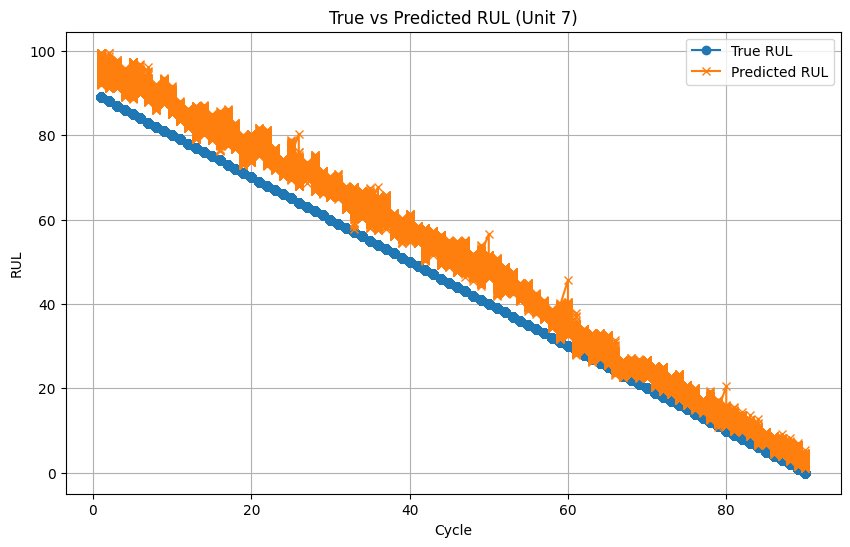

In [11]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from src.cnn import load_model

# model laden
model = load_model(model, CHECKPOINT_PATH, DEVICE)
# Unit zum Plotten auswählen
test_unit_no = 7

# Daten für die ausgewählte Unit extrahieren
unit_data = df_testing_scaled[
    df_testing_scaled["unit"] == test_unit_no
]
unit_data_raw = df_testing[
    df_testing["unit"] == test_unit_no
]  # unscaled, for real cycle numbers

# Für Forward Pass
X_test_unit: list[Tensor] = []
y_test_unit: list[Tensor] = []
# Für x-Achse im Plotten (echte Zyklenzahl, nicht skaliert)
cycles_test_unit: list[int] = []

# Erstellen von Testdaten im Window-Format für die ausgewählte Unit
for i in range(0, len(unit_data) - WIN_LEN + 1):
    temp = unit_data.iloc[i : i + WIN_LEN]  # skaliert, für die Vorhersage
    temp_raw = unit_data_raw.iloc[
        i : i + WIN_LEN
    ]  # unskaliert, für die echten Zyklenzahlen
    x_temp = temp.drop(columns=["unit", "RUL"]).values
    y_temp = temp["RUL"].values[-1]
    X_test_unit.append(x_temp)
    y_test_unit.append(y_temp)
    cycles_test_unit.append(temp_raw["cycle"].values[-1])

X_test_tensor: Tensor = torch.tensor(X_test_unit, dtype=torch.float32)
dataset: TensorDataset = TensorDataset(X_test_tensor)
loader: DataLoader = DataLoader(dataset, batch_size=64, shuffle=False)

predictions: list[Tensor] = []
# forward pass, ohne Gradientenberechnung, da nur Predictions berechnet werden
with torch.no_grad():
    for (batch,) in loader:
        batch = batch.to(DEVICE).unsqueeze(1)  # (B, 1, 10, 36)
        batch_pred = model(batch)
        predictions.append(batch_pred.cpu())

# Predictions zusammenfügen, in numpy-Array umwandeln und flatten
y_pred = torch.cat(predictions).numpy().flatten()

plt.figure(figsize=(10, 6))
plt.plot(cycles_test_unit, y_test_unit, label="True RUL", marker="o")
plt.plot(cycles_test_unit, y_pred, label="Predicted RUL", marker="x")
plt.title(f"True vs Predicted RUL (Unit {test_unit_no})")
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()


## Interactive RUL Prediction Demo

Wähle eine Triebwerkseinheit und ziehe den Slider, um festzulegen, wie viele Zyklen an Daten bekannt sein sollen. Die rote gestrichelte Linie markiert den aktuellen Zeitpunkt – alles links davon sind beobachtete Daten, und die Vorhersage zeigt, was das Modell zu diesem Zeitpunkt ausgeben würde.


In [ ]:
import ipywidgets as widgets
from IPython.display import display
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch
from src.cnn import load_model
from IPython.display import clear_output

model = load_model(model, CHECKPOINT_PATH, DEVICE)

# Data Loading
print("=" * 50)
print("Pre-computing predictions for all units…")
print("=" * 50, flush=True)

unit_cache: dict[int, dict[str, np.ndarray]] = {}
available_units: list[int] = sorted(
    df_testing["unit"].unique().astype(int).tolist()
)
total_units: int = len(available_units)

for idx_u, unit_no in enumerate(available_units, start=1):
    print(
        f"[{idx_u}/{total_units}] Processing unit {unit_no}…",
        end=" ",
        flush=True,
    )

    unit_scaled: pd.DataFrame = df_testing_scaled[
        df_testing_scaled["unit"] == unit_no
    ].reset_index(drop=True)
    unit_raw: pd.DataFrame = df_testing[
        df_testing["unit"] == unit_no
    ].reset_index(drop=True)

    if len(unit_scaled) < WIN_LEN:
        unit_cache[unit_no] = {"cycles": [], "y_true": [], "y_pred": []}
        print("skipped (not enough cycles).", flush=True)
        continue

    n: int = len(unit_scaled)
    feat_cols: list[str] = [
        c for c in unit_scaled.columns if c not in ("unit", "RUL")
    ]
    X_arr: np.ndarray = unit_scaled[feat_cols].values

    print(f"{n} rows -> {n - WIN_LEN + 1} windows…", end=" ", flush=True)

    X_windows: np.ndarray = np.stack(
        [X_arr[i : i + WIN_LEN] for i in range(n - WIN_LEN + 1)]
    )

    y_true_list, cycles_list = [], []
    for i in range(n - WIN_LEN + 1):
        y_true_list.append(unit_scaled["RUL"].values[i + WIN_LEN - 1])
        cycles_list.append(unit_raw["cycle"].values[i + WIN_LEN - 1])
    y_true_arr: np.ndarray = np.array(y_true_list)
    cycles_arr = np.array(cycles_list)

    X_tensor: Tensor = torch.tensor(X_windows, dtype=torch.float32)
    loader: DataLoader = DataLoader(
        TensorDataset(X_tensor), batch_size=256, shuffle=False
    )

    preds: list[Tensor] = []
    with torch.no_grad():
        for (batch,) in loader:
            preds.append(model(batch.to(DEVICE).unsqueeze(1)).cpu())

    y_pred_arr: np.ndarray = torch.cat(preds).numpy().flatten()

    unit_cache[unit_no]: dict[str, np.ndarray] = {
        "cycles": cycles_arr,
        "y_true": y_true_arr,
        "y_pred": y_pred_arr,
    }

    rul_range = f"RUL [{y_true_arr.min():.0f}–{y_true_arr.max():.0f}]"
    print(f"done. {rul_range}", flush=True)

print("=" * 50)
print(f"All {total_units} units cached. Widgets are ready.")
print("=" * 50, flush=True)


# Plotting
def plot_agent(unit_no: int, cycle_cutoff: int) -> None:
    plt.close("all")

    cache: dict[str, np.ndarray] = unit_cache[unit_no]
    cycles: np.ndarray = np.array(cache["cycles"])
    y_true: np.ndarray = np.array(cache["y_true"])
    y_pred: np.ndarray = np.array(cache["y_pred"])

    if len(cycles) == 0:
        print(f"Unit {unit_no}: not enough cycles.")
        return

    # Observed: all windows whose last cycle <= cutoff
    mask_obs: np.ndarray = cycles <= cycle_cutoff

    if not mask_obs.any():
        print(f"Unit {unit_no}: no observed windows at cycle {cycle_cutoff}.")
        return

    obs_cycles: np.ndarray = cycles[mask_obs]
    obs_true: np.ndarray = y_true[mask_obs]
    obs_pred: np.ndarray = y_pred[mask_obs]

    # Forecast: windows AFTER cutoff — model already saw these during caching
    mask_fore: np.ndarray = cycles > cycle_cutoff
    fore_cycles: np.ndarray = cycles[mask_fore]
    fore_pred: np.ndarray = y_pred[mask_fore]

    # RUL at cutoff = last predicted value in observed window
    rul_at_cutoff: float = obs_pred[-1]

    fig, ax = plt.subplots(figsize=(13, 5))

    # True RUL (solid blue)
    ax.plot(
        obs_cycles,
        obs_true,
        color="steelblue",
        linewidth=1.8,
        marker="o",
        markersize=2.5,
        label="True RUL (observed)",
    )

    # Predicted RUL in observed range (solid orange)
    ax.plot(
        obs_cycles,
        obs_pred,
        color="darkorange",
        linewidth=1.5,
        marker="x",
        markersize=2.5,
        label="Predicted RUL (observed)",
    )

    # Forecast: connect smoothly from last observed pred into future (dashed)
    if mask_fore.any():
        # Prepend the last observed point so the dashed line starts without a gap
        fore_cycles_full: np.ndarray = np.concatenate(
            [[obs_cycles[-1]], fore_cycles]
        )
        fore_pred_full: np.ndarray = np.concatenate(
            [[rul_at_cutoff], fore_pred]
        )
        ax.plot(
            fore_cycles_full,
            fore_pred_full,
            color="darkorange",
            linewidth=2.0,
            linestyle="--",
            marker="",
            label="Predicted RUL (forecast)",
        )

    # Cutoff line
    ax.axvline(
        cycle_cutoff,
        color="crimson",
        linestyle="--",
        linewidth=2.0,
        label=f"Now — cycle {cycle_cutoff}",
    )

    # RUL annotation
    ax.annotate(
        f"  RUL ≈ {rul_at_cutoff:.0f} cycles",
        xy=(cycle_cutoff, rul_at_cutoff),
        xytext=(
            cycle_cutoff + (cycles.max() - cycles.min()) * 0.03,
            rul_at_cutoff,
        ),
        fontsize=11,
        color="crimson",
        arrowprops=dict(arrowstyle="->", color="crimson", lw=1.2),
    )

    ax.set_title(
        f"RUL Prediction  |  Unit {unit_no}  |  Observed up to cycle {cycle_cutoff}",
        fontsize=13,
        fontweight="bold",
    )
    ax.set_xlabel("Cycle", fontsize=11)
    ax.set_ylabel("RUL (cycles remaining)", fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.35)
    plt.tight_layout()
    display(fig)
    plt.close(fig)


# Widgets
max_cycle: int = int(df_testing["cycle"].max())

unit_widget: widgets.Dropdown = widgets.Dropdown(
    options=available_units,
    value=available_units[0],
    description="Engine Unit:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="300px"),
)

cycle_widget: widgets.IntSlider = widgets.IntSlider(
    min=WIN_LEN,
    max=max_cycle,
    step=1,
    value=50,
    description="Current cycle:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="600px"),
    continuous_update=False,
)

out: widgets.interactive = widgets.interactive_output(
    plot_agent, {"unit_no": unit_widget, "cycle_cutoff": cycle_widget}
)
display(widgets.VBox([widgets.HBox([unit_widget]), cycle_widget, out]))

Pre-computing predictions for all units…
[1/4] Processing unit 7… 392585 rows -> 392576 windows… done. RUL [0–89]
[2/4] Processing unit 8… 800294 rows -> 800285 windows… done. RUL [0–88]
[3/4] Processing unit 9… 351683 rows -> 351674 windows… done. RUL [0–79]
[4/4] Processing unit 10… 1190670 rows -> 1190661 windows… done. RUL [0–81]
All 4 units cached. Widgets are ready.
